In [2]:
import matplotlib.pyplot as plt

from prysm import mathops, conf
mathops.set_backend_to_cupy()
# conf.config.precision = 32

from prysm.mathops import (np,
                           fft,
                           interpolate,
                           ndimage)

from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.propagation import focus_fixed_sampling
from prysm.propagation import Wavefront as WF
from prysm.geometry import circle,spider
from prysm.polynomials import (
    noll_to_nm,
    zernike_nm,
    zernike_nm_seq,
    hopkins,
    sum_of_2d_modes
)


from lina.phase_retrieval import ADPhaseRetireval, ParallelADPhaseRetrieval

from scipy.optimize import minimize
from psd_utils import PSDUtils

import logging
psd_log = logging.getLogger('__psd_utils__')
psd_log.disabled = True

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Model Parameters

Text(0.5, 0, 'mm')

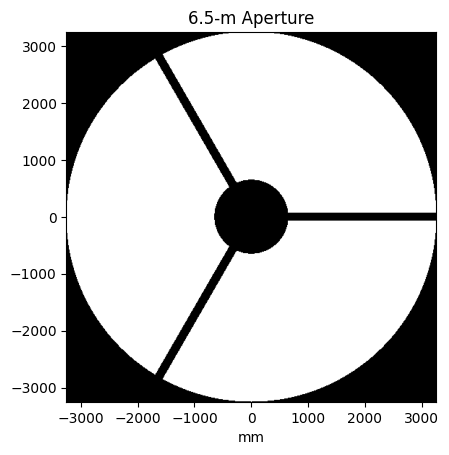

In [3]:
# parameters
D_pupil = 6500                              # mm
D_obs = 1300                                # mm
D_spider = 150                              # mm
fno = 15                                    # dimensionless
efl = fno * D_pupil                         # mm
wvls = list(np.linspace(0.575, 0.725, 25).get())  # um [0.633]
npix_pupil = 512                            # pix
dx_pupil = D_pupil / npix_pupil


# grids
x, y = make_xy_grid(npix_pupil, diameter=D_pupil)
r, t = cart_to_polar(x, y)
extent_pupil = [-D_pupil / 2, D_pupil / 2, -D_pupil / 2, D_pupil / 2]

# image space
angular_res = (wvls[-1] + wvls[0] / 2) * 1e-6 * fno 
platescale = 3.76e-6 / angular_res
extent_image = [-platescale * 64, platescale * 64, -platescale * 64, platescale * 64]

# aperture
s1 = spider(1, D_spider, x, y, rotation=0)
s2 = spider(1, D_spider, x, y, rotation=120)
s3 = spider(1, D_spider, x, y, rotation=240)
spiders = s1 & s2 & s3
A = (circle(D_pupil / 2, r) ^ circle(D_obs / 2, r)) & spiders
# A = circle(D_pupil / 2, r)

plt.imshow(A.get(), extent=extent_pupil ,cmap='gray')
plt.title("6.5-m Aperture")
plt.xlabel("mm")

## High-Order Error

PSD now scaled to RMS.
PSD now scaled to RMS.
PSD now scaled to RMS.
PSD now scaled to RMS.


Text(0.5, 1.0, 'Optical Surface Error\nRMS: 28.1 nm')

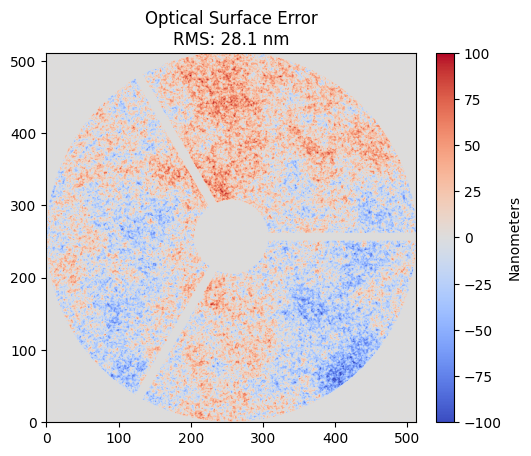

In [4]:
# surface error
coords = PSDUtils.coord_arrays(dims=(npix_pupil, npix_pupil), dx=D_pupil / 1e3 / npix_pupil)
psd = PSDUtils.abc_psd(coords=coords, a=1, b=0.1, c=2.8, rms=18.8, rms_scaling=True)
surface_error = np.asarray(PSDUtils.create_map(coords, psd, rms=18.8, seed=727).map) * A
for i in range(3):
    psd = PSDUtils.abc_psd(coords=coords, a=1, b=10, c=2.65, rms=12, rms_scaling=True)
    surface_error += np.asarray(PSDUtils.create_map(coords, psd, rms=12, seed=i + 73).map) * A

plt.imshow(surface_error.get(), vmin=-100, vmax=100, cmap='coolwarm')
plt.colorbar(fraction=0.046, pad=0.04, label='Nanometers')
plt.title("Optical Surface Error\nRMS: {:0.1f} nm".format(np.sqrt(np.mean(surface_error[surface_error != 0] ** 2))))

## Low-Order Error

/home/derbyk/src/prysm/prysm/polynomials/__init__.py:107: UserWarning: sum_of_2d_modes: modes is a list or tuple: for optimal performance, pre convert to array of shape (k, m, n)
  warnings.warn('sum_of_2d_modes: modes is a list or tuple: for optimal performance, pre convert to array of shape (k, m, n)')


Text(0.5, 0, 'mm')

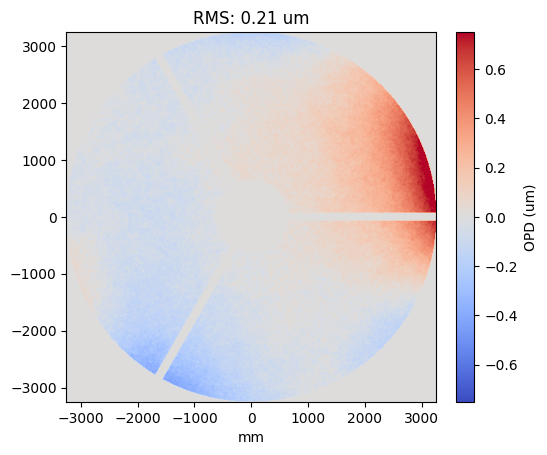

In [5]:
# zernike basis
r_norm = r / (D_pupil / 2)
nms = [noll_to_nm(i) for i in range(2, 37)]
zernikes = list(zernike_nm_seq(nms, r, t, norm=True))
zernikes = [z / np.max(np.abs(z)) for z in zernikes]

# random phase error to estimate
np.random.seed(20240820)
zernike_coeffs = np.random.random(len(nms)) * 0.2
opd = sum_of_2d_modes(zernikes, zernike_coeffs) + surface_error / 1e3

plt.imshow(opd.get() * A.get(), extent=extent_pupil, vmin=-0.75, vmax=0.75, cmap='coolwarm')
plt.colorbar(pad=0.04, fraction=0.046, label="OPD (um)")
plt.title(f"RMS: {np.sqrt(np.mean(opd[opd != 0] ** 2)):0.2f} um")
plt.xlabel("mm")

## Forward Model

<>:38: SyntaxWarning: invalid escape sequence '\l'
<>:38: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_621958/2957956712.py:38: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f"Defocus: {defocus_values[i]:0.2f}$\lambda$")


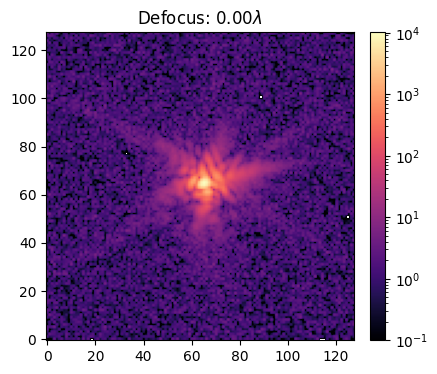

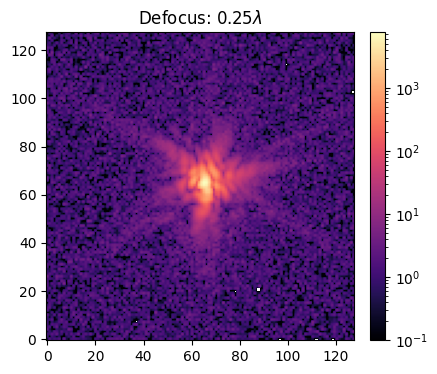

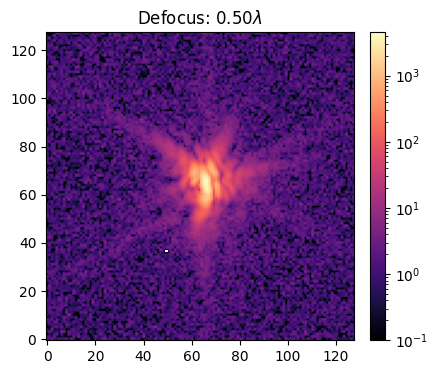

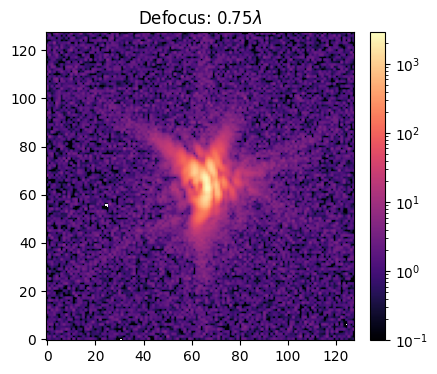

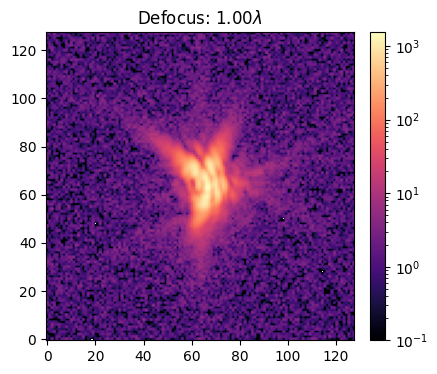

In [6]:
def fwd(opd, defocus_values):

    # defocus OPDs
    defocus_opds = [hopkins(0, 2, 0, r_norm, t, 0) * val for val in defocus_values]

    psf_list = []

    # propagate PSFs
    for defocus_opd in defocus_opds:
        psf = 0
        for wvl in wvls:
            k = 2 * np.pi / wvl
            wf = A * np.exp(1j * k * opd)
            defocus = A * np.exp(-2j * np.pi * defocus_opd)
            mono = focus_fixed_sampling(wavefunction=wf * defocus,
                                    input_dx=dx_pupil,
                                    prop_dist=efl,
                                    wavelength=wvl,
                                    output_dx=3.76,
                                    output_samples=128)
            psf += np.abs(mono) ** 2 / len(wvls)

            psf += np.random.normal(loc=0, scale=0.3, size=(psf.shape[0], psf.shape[1]))
            psf[psf < 0] = 0
            
        psf_list.append(psf)

    return psf_list

defocus_values = np.asarray([0, 0.25, 0.5, 0.75, 1])

psfs = fwd(opd, defocus_values)

for i, psf in enumerate(psfs):
    plt.figure(figsize=(5, 4))
    plt.imshow(psf.get(), cmap='magma', norm='log', vmin=1e-1)
    plt.colorbar(pad=0.04, fraction=0.046)
    plt.title(f"Defocus: {defocus_values[i]:0.2f}$\lambda$")

## FDPR

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_621958/2940382720.py:23: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(np.asarray(opt.cost).get(), label=f'Defocus: {defocus_values[i]:0.2f}$\lambda$', alpha=0.4)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66108D+00    |proj g|=  1.31486D+01

At iterate    1    f=  1.63418D+00    |proj g|=  1.05096D+01

At iterate    2    f=  8.83353D-01    |proj g|=  2.64794D+00

At iterate    3    f=  7.24083D-01    |proj g|=  1.90159D+00

At iterate    4    f=  5.27123D-01    |proj g|=  2.16941D+00

At iterate    5    f=  2.84213D-01    |proj g|=  2.03262D+00

At iterate    6    f=  1.39190D-01    |proj g|=  1.80623D+00

At iterate    7    f=  1.36345D-01    |proj g|=  1.25089D+00

At iterate    8    f=  1.13041D-01    |proj g|=  4.12448D-01

At iterate    9    f=  1.09460D-01    |proj g|=  2.28844D-01

At iterate   10    f=  9.74258D-02    |proj g|=  5.19572D-01

At iterate   11    f=  8.70705D-02    |proj g|=  6.63080D-01

At iterate   12    f=  6.79583D-02    |proj g|=  4.15488D-01

At iterate   13    f=  5.1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


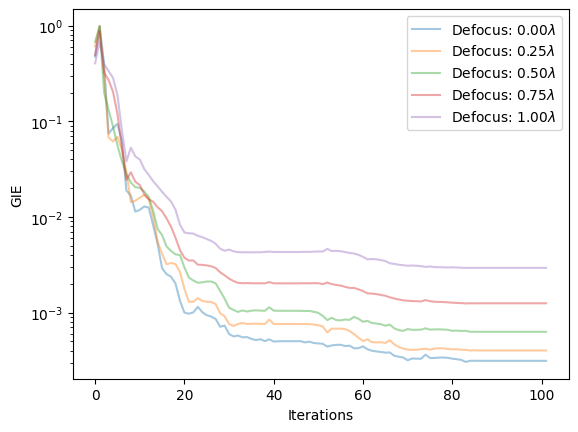

In [7]:
error_fx = 'GIE'
adpr_list = []

for defocus_value, psf in zip(defocus_values, psfs):
    adpr_list.append(ADPhaseRetireval(amp=A,
                                          amp_dx=dx_pupil,
                                          efl=efl,
                                          wvls=wvls,
                                          basis=np.asarray(zernikes),
                                          target=psf,
                                          img_dx=3.76,
                                          defocus_waves=defocus_value,
                                          initial_phase=None,
                                          error_function=error_fx))

fdpr = ParallelADPhaseRetrieval(optlist=adpr_list)

results = minimize(fdpr.fg, x0=np.zeros(len(zernike_coeffs)).get(),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'ftol': 1e-20, 'gtol': 1e-8, 'disp': 1, 'maxiter':1000})

for i, opt in enumerate(fdpr.optlist):
    plt.plot(np.asarray(opt.cost).get(), label=f'Defocus: {defocus_values[i]:0.2f}$\lambda$', alpha=0.4)
plt.ylabel(error_fx)
plt.xlabel('Iterations')
plt.legend(loc='upper right')
plt.yscale('log')
plt.show()

## Visualize Results

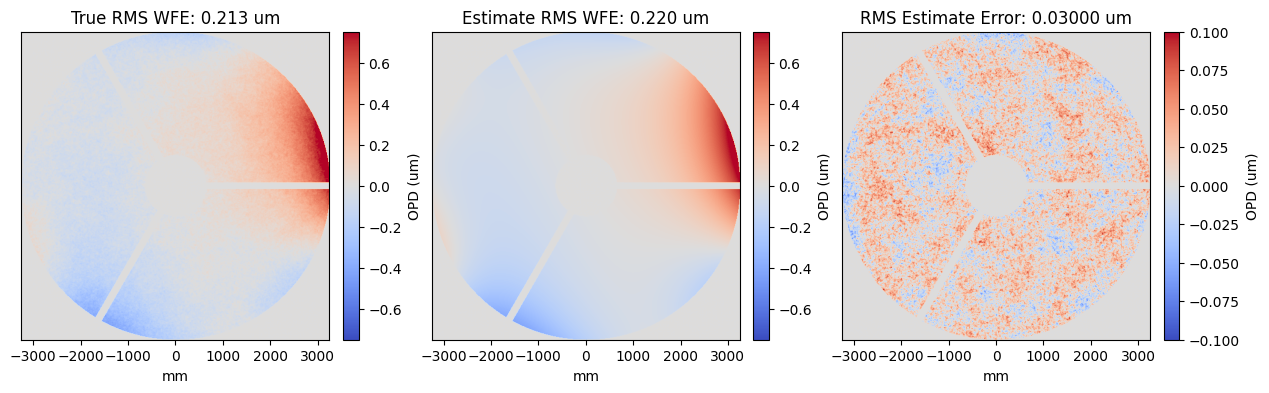

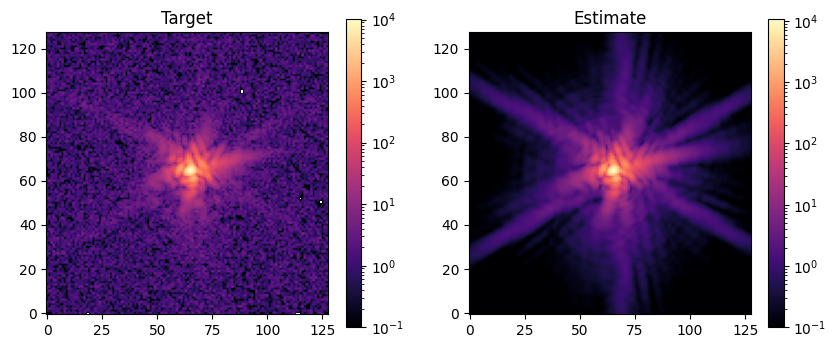

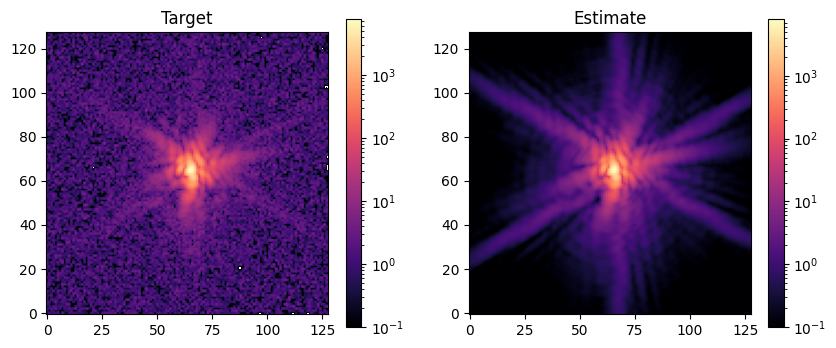

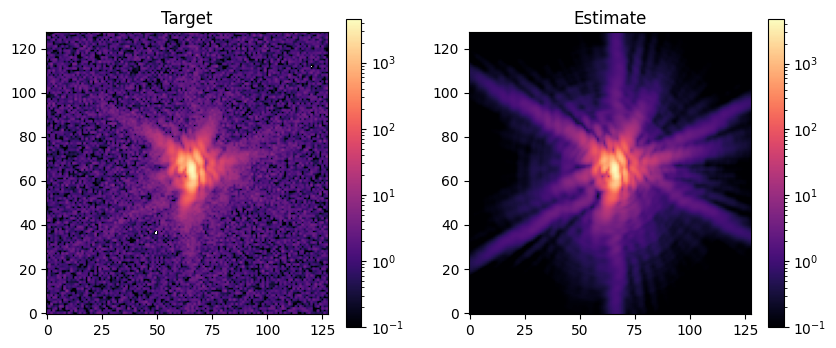

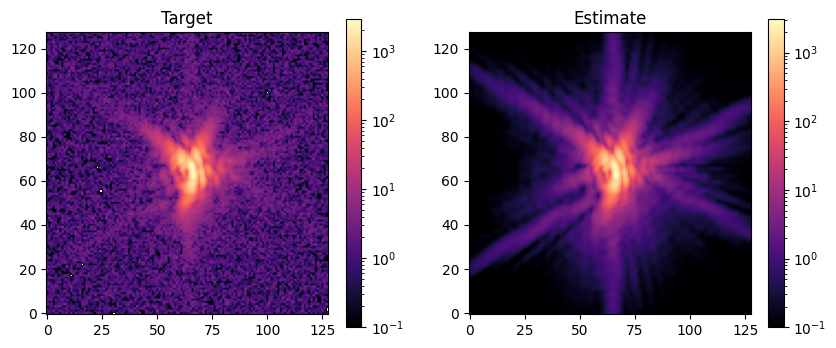

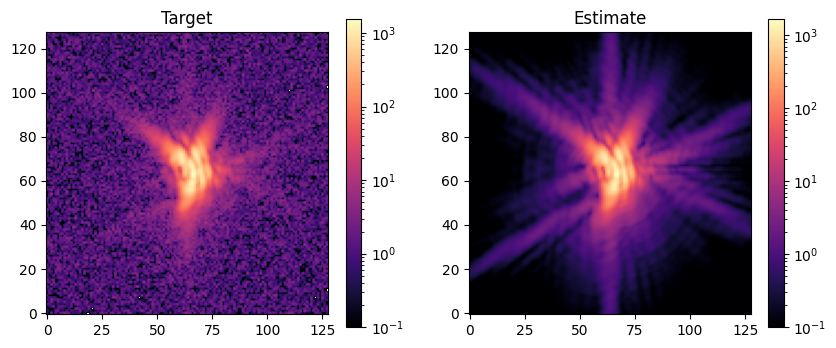

In [9]:
adpr_focus = fdpr.optlist[1]
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.imshow(opd.get() * A.get(), extent=extent_pupil, vmin=-0.75, vmax=0.75, cmap='coolwarm')
plt.colorbar(pad=0.04, fraction=0.046, label="OPD (um)")
plt.title(f"True RMS WFE: {np.sqrt(np.mean(opd[opd != 0] ** 2)):0.3f} um")
plt.xlabel("mm"); plt.yticks([])
plt.subplot(132)
plt.imshow(adpr_focus.phs.get() * A.get(), extent=extent_pupil, vmin=-0.75, vmax=0.75, cmap='coolwarm')
plt.colorbar(pad=0.04, fraction=0.046, label="OPD (um)")
plt.title(f"Estimate RMS WFE: {np.sqrt(np.mean(adpr_focus.phs[adpr_focus.phs != 0] ** 2)):0.3f} um")
plt.xlabel("mm"); plt.yticks([])
diff = opd - adpr_focus.phs
plt.subplot(133)
plt.imshow(diff.get() * A.get(), extent=extent_pupil, vmin=-0.1, vmax=0.1, cmap='coolwarm')
plt.colorbar(pad=0.04, fraction=0.046, label="OPD (um)")
plt.title(f"RMS Estimate Error: {np.sqrt(np.mean(diff[diff != 0] ** 2)):0.5f} um")
plt.xlabel("mm"); plt.yticks([])

for adpr in fdpr.optlist:
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.title('Target')
    plt.imshow(adpr.D.get(), norm='log', cmap='magma', vmin=1e-1)
    plt.colorbar()
    plt.subplot(122)
    plt.title('Estimate')
    plt.imshow(adpr.I.get(), norm='log', cmap='magma', vmin=1e-1)
    plt.colorbar()
    plt.show()